In [1]:
getwd()
if ( is.null(environment()$this_notebook_dir) ) {
    this_notebook_dir <- getwd()
    setwd(paste0(getwd(), '/..'))
}
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/NA_fix"

[1] "/mnt/hdd/develop/kaggle/house-prices/R"

In [2]:
source('helpers.R')

kaggle.house.loadLibraries()
data <- kaggle.house.loadData()

df.LotFrontage <- data$combined %>% filter(!is.na(LotFrontage))

df.LotFrontage.vs.numeric <- df.LotFrontage %>% select_if(is.numeric)

df.LotFrontage.vs.char <- df.LotFrontage %>% 
    select(starts_with('LotFrontage'),  
           which(sapply(df.LotFrontage, is.character)) %>% names)

df.LotFrontage %>% dim
df.LotFrontage.vs.numeric %>% dim
df.LotFrontage.vs.char %>% dim

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths


Attaching package: ‘purrr’

The following object is masked from ‘package:caret’:

    lift



[1] 2433   80

[1] 2433   35

[1] 2433   46

In [3]:
df.LotFrontage.vs.numeric %>%
gather(attr.name, attr.val, -LotFrontage) %>%
filter(!is.na(attr.val)) %>%
mutate(
    attr.val.log = ifelse(attr.val > 0, log(attr.val), 0),
    LotFrontage.log = log(LotFrontage)
) -> df.LotFrontage.vs.numeric.long

df.LotFrontage.vs.numeric.long %>% head
df.LotFrontage.vs.numeric.long %>% count

LotFrontage,attr.name,attr.val,attr.val.log,LotFrontage.log
65,LotArea,8450,9.041922,4.174387
80,LotArea,9600,9.169518,4.382027
68,LotArea,11250,9.328123,4.219508
60,LotArea,9550,9.164296,4.094345
84,LotArea,14260,9.565214,4.430817
85,LotArea,14115,9.554993,4.442651


n
82547


In [4]:
df.LotFrontage.vs.numeric.long %>% 
group_by(attr.name) %>% 
nest %>% 
mutate(
    mod = map(data, ~lm(LotFrontage ~ attr.val, .)), 
    glance = map(mod, broom::glance),
    rsq = glance %>% map_dbl("r.squared"),
    
    mod2 = map(data, ~lm(LotFrontage ~ attr.val.log, .)), 
    glance2 = map(mod2, broom::glance),
    rsq2 = glance2 %>% map_dbl("r.squared"),
    
    mod3 = map(data, ~lm(LotFrontage.log ~ attr.val.log, .)), 
    glance3 = map(mod3, broom::glance),
    rsq3 = glance3 %>% map_dbl("r.squared")
) %>%
arrange(desc(rsq)) %>%
select(attr.name, rsq, rsq2, rsq3) %>%
print

# A tibble: 34 x 4
      attr.name        rsq        rsq2        rsq3
          <chr>      <dbl>       <dbl>       <dbl>
 1      LotArea 0.23999767 0.467189030 0.587193938
 2    X1stFlrSF 0.20999074 0.210587817 0.218847392
 3    GrLivArea 0.14627714 0.125415343 0.108557166
 4   GarageArea 0.12944610 0.033312216 0.033526172
 5  TotalBsmtSF 0.12589894 0.008013407 0.007024319
 6 TotRmsAbvGrd 0.12215963 0.123642972 0.126792650
 7   GarageCars 0.09646429 0.090350458 0.077319103
 8   Fireplaces 0.06862818 0.030197358 0.022495100
 9 BedroomAbvGr 0.05517420 0.060886185 0.074960584
10   MasVnrArea 0.04887582 0.038520767 0.023899711
# ... with 24 more rows


In [5]:
df.LotFrontage.vs.numeric %>%
gather(attr.name, attr.val, -LotFrontage, -LotArea) %>%
filter(!is.na(attr.val)) %>%
mutate(
    attr.val.log = ifelse(attr.val > 0, log(attr.val), 0),
    LotFrontage.log = log(LotFrontage),
    LotArea.log = log(LotArea)
) %>%
select(-LotFrontage, -LotArea) -> df.LotFrontage.vs.numeric.long2

df.LotFrontage.vs.numeric.long2 %>% head
df.LotFrontage.vs.numeric.long2 %>% count

attr.name,attr.val,attr.val.log,LotFrontage.log,LotArea.log
OverallQual,7,1.945910,4.174387,9.041922
OverallQual,6,1.791759,4.382027,9.169518
OverallQual,7,1.945910,4.219508,9.328123
OverallQual,7,1.945910,4.094345,9.164296
OverallQual,8,2.079442,4.430817,9.565214
OverallQual,5,1.609438,4.442651,9.554993


n
80114


In [6]:
df.LotFrontage.vs.numeric.long2 %>% 
group_by(attr.name) %>% 
nest %>% 
mutate(
    mod = map(data, ~lm(LotFrontage.log ~ LotArea.log, .)), 
    glance = map(mod, broom::glance),
    rsq = glance %>% map_dbl("r.squared"),
    
    mod1 = map(data, ~lm(LotFrontage.log ~ LotArea.log + attr.val, .)), 
    glance1 = map(mod1, broom::glance),
    rsq1 = glance1 %>% map_dbl("r.squared"),
    
    mod2 = map(data, ~lm(LotFrontage.log ~ LotArea.log + attr.val.log, .)), 
    glance2 = map(mod2, broom::glance),
    rsq2 = glance2 %>% map_dbl("r.squared")
) %>%
arrange(desc(rsq2)) %>%
select(attr.name, rsq, rsq1, rsq2) %>%
print

# A tibble: 33 x 4
      attr.name       rsq      rsq1      rsq2
          <chr>     <dbl>     <dbl>     <dbl>
 1    X1stFlrSF 0.5871939 0.5952974 0.5986197
 2   MasVnrArea 0.5886948 0.5922331 0.5943946
 3 BedroomAbvGr 0.5871939 0.5912319 0.5936016
 4 TotRmsAbvGrd 0.5871939 0.5918779 0.5929072
 5   GarageCars 0.5873755 0.5915473 0.5908690
 6    X2ndFlrSF 0.5871939 0.5878356 0.5897907
 7    BsmtUnfSF 0.5882109 0.5912117 0.5895906
 8    GrLivArea 0.5871939 0.5891953 0.5892236
 9  TotalBsmtSF 0.5882109 0.5926353 0.5885418
10  OverallQual 0.5871939 0.5888413 0.5885256
# ... with 23 more rows


In [7]:
df.LotFrontage.vs.char %>%
gather(attr.name, attr.val, -LotFrontage) %>%
filter(!is.na(attr.val)) %>%
group_by(attr.name) %>%
filter(n_distinct(attr.val) > 1) %>%
mutate(
    LotFrontage.log = log(LotFrontage)
) -> df.LotFrontage.vs.char.long

df.LotFrontage.vs.char.long %>% head
df.LotFrontage.vs.char.long %>% dim

LotFrontage,attr.name,attr.val,LotFrontage.log
65,MSSubClass,60,4.174387
80,MSSubClass,20,4.382027
68,MSSubClass,60,4.219508
60,MSSubClass,70,4.094345
84,MSSubClass,60,4.430817
85,MSSubClass,50,4.442651


[1] 95865     4

In [8]:
df.LotFrontage.vs.char.long %>% 
group_by(attr.name) %>% 
nest %>% 
mutate(
    mod1 = map(data, ~lm(LotFrontage ~ attr.val, .)), 
    glance1 = map(mod1, broom::glance),
    rsq1 = glance1 %>% map_dbl("r.squared"),
    
    mod2 = map(data, ~lm(LotFrontage.log ~ attr.val, .)), 
    glance2 = map(mod2, broom::glance),
    rsq2 = glance2 %>% map_dbl("r.squared")
) %>%
arrange(desc(rsq2)) %>%
select(attr.name, rsq1, rsq2) %>%
print

# A tibble: 44 x 3
      attr.name       rsq1       rsq2
          <chr>      <dbl>      <dbl>
 1   MSSubClass 0.35397282 0.56689967
 2     BldgType 0.27873183 0.49821725
 3 Neighborhood 0.26761868 0.41942559
 4        Alley 0.15870576 0.22724337
 5     MSZoning 0.13744685 0.18531266
 6       PoolQC 0.17120892 0.17614046
 7  Exterior2nd 0.06735684 0.10855302
 8   GarageType 0.09624769 0.08976496
 9    LotConfig 0.07566657 0.07174850
10  Exterior1st 0.04085280 0.05812463
# ... with 34 more rows


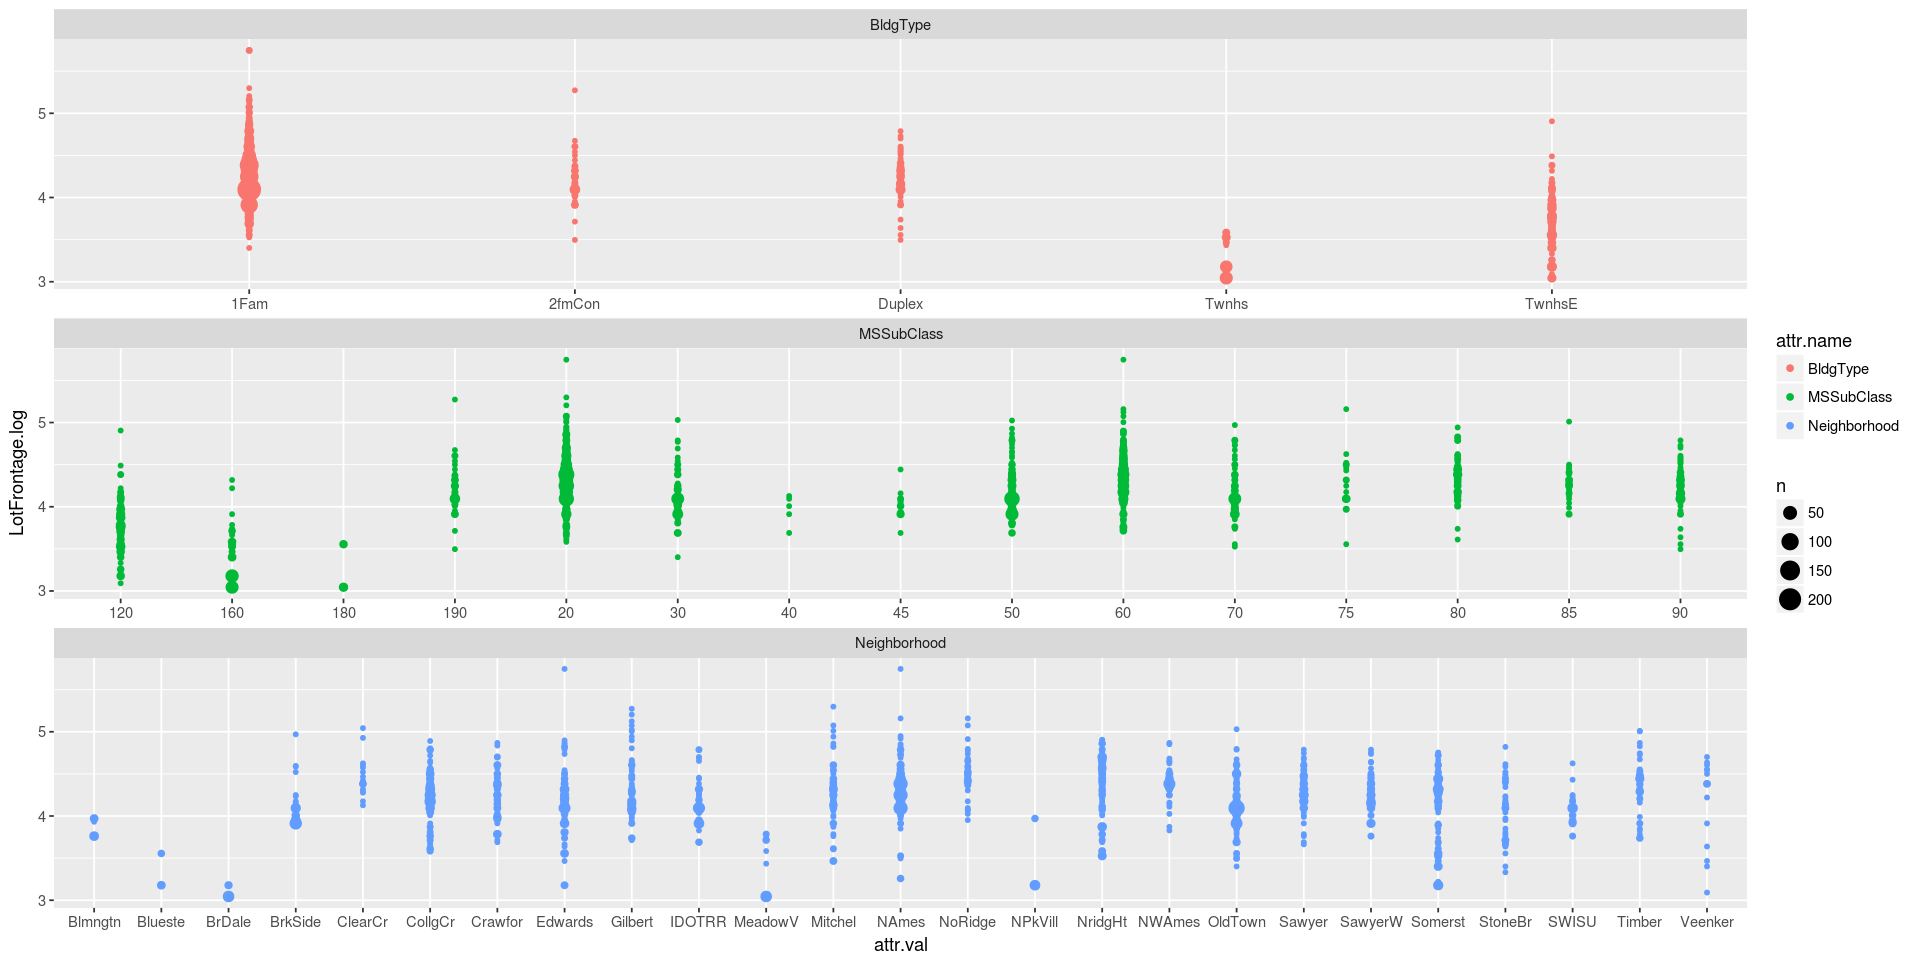

In [9]:
options(repr.plot.width = 16, repr.plot.height = 8)

df.LotFrontage.vs.char.long %>%
filter(attr.name %in% c('MSSubClass', 'BldgType', 'Neighborhood')) %>%
group_by(attr.name) %>% 
ggplot() +
    geom_count(aes(x=attr.val, y=LotFrontage.log, color=attr.name)) +
    facet_wrap(~attr.name, scales = "free_x", ncol=1)

In [10]:
df.LotFrontage %>%
select(LotFrontage, LotArea, MSSubClass, BldgType, Neighborhood) %>%
na.omit %>%
mutate(
    LotArea.log = log(LotArea),
    LotFrontage.log = log(LotFrontage)
) -> df

df.LotFrontage %>% dim
df %>% dim

model.lm <- lm(LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + Neighborhood, data = df) 
model.lm %>% summary

[1] 2433   80

[1] 2433    7


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + 
    Neighborhood, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92465 -0.08363 -0.00265  0.08893  1.12802 

Coefficients: (1 not defined because of singularities)
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.737464   0.159930  10.864  < 2e-16 ***
LotArea.log          0.285930   0.013799  20.721  < 2e-16 ***
MSSubClass160       -0.101066   0.032702  -3.091 0.002021 ** 
MSSubClass180       -0.096273   0.059631  -1.614 0.106558    
MSSubClass190        0.133030   0.174620   0.762 0.446238    
MSSubClass20         0.116004   0.102021   1.137 0.255626    
MSSubClass30         0.044662   0.104281   0.428 0.668479    
MSSubClass40        -0.112011   0.135235  -0.828 0.407602    
MSSubClass45        -0.019380   0.112592  -0.172 0.863352    
MSSubClass50         0.030211   0.103306   0.292 0.769972    
MSSubClass60         0.110769   0.102339   1.082 0.2

In [11]:
library(Matrix)
mm <- model.matrix(model.lm)
rankMatrix(mm)
dim(mm)
cor(mm[,'BldgTypeDuplex'], mm[, 'MSSubClass90'])


Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



[1] 43
attr(,"method")
[1] "tolNorm2"
attr(,"useGrad")
[1] FALSE
attr(,"tol")
[1] 5.402345e-13

[1] 2433   44

[1] 1

In [12]:
df.LotFrontage %>%
select(LotFrontage, LotArea, MSSubClass, BldgType, Neighborhood) %>%
na.omit %>%
mutate(
    LotArea.log = log(LotArea),
    LotFrontage.log = log(LotFrontage),
    BldgType = ifelse(BldgType %in% c('Duplex', '2fmCon'), 'Duplex+2fmCon', BldgType)
) -> df

df.LotFrontage %>% dim
df %>% dim

model2.lm <- lm(LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + Neighborhood, data = df) 
model2.lm %>% summary

[1] 2433   80

[1] 2433    7


Call:
lm(formula = LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + 
    Neighborhood, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.92465 -0.08363 -0.00265  0.08893  1.12802 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.737464   0.159930  10.864  < 2e-16 ***
LotArea.log            0.285930   0.013799  20.721  < 2e-16 ***
MSSubClass160         -0.101066   0.032702  -3.091 0.002021 ** 
MSSubClass180         -0.096273   0.059631  -1.614 0.106558    
MSSubClass190          0.133030   0.174620   0.762 0.446238    
MSSubClass20           0.116004   0.102021   1.137 0.255626    
MSSubClass30           0.044662   0.104281   0.428 0.668479    
MSSubClass40          -0.112011   0.135235  -0.828 0.407602    
MSSubClass45          -0.019380   0.112592  -0.172 0.863352    
MSSubClass50           0.030211   0.103306   0.292 0.769972    
MSSubClass60           0.110769   0.102339   1.082 0.279199    
MSSubCl

In [13]:
model.augment = broom::augment(model2.lm)
model.augment %>% head

LotFrontage.log,LotArea.log,MSSubClass,BldgType,Neighborhood,.fitted,.se.fit,.resid,.hat,.sigma,.cooksd,.std.resid
4.174387,9.041922,60,1Fam,CollgCr,4.203164,0.01567526,-0.02877634,0.006370533,0.1964336,3.221632e-06,-0.1469930
4.382027,9.169518,20,1Fam,Veenker,4.192400,0.05032012,0.18962621,0.065649258,0.1963934,1.630364e-03,0.9988876
4.219508,9.328123,60,1Fam,CollgCr,4.284997,0.01564388,-0.06548957,0.006345059,0.1964299,1.661831e-05,-0.3345242
4.094345,9.164296,70,1Fam,Crawfor,4.231501,0.02571350,-0.13715654,0.017142285,0.1964141,2.012790e-04,-0.7044407
4.430817,9.565214,60,1Fam,NoRidge,4.537375,0.02689649,-0.10655788,0.018755889,0.1964221,1.333622e-04,-0.5477347
4.442651,9.554993,50,1Fam,Mitchel,4.287541,0.02664240,0.15511044,0.018403188,0.1964083,2.770683e-04,0.7971640


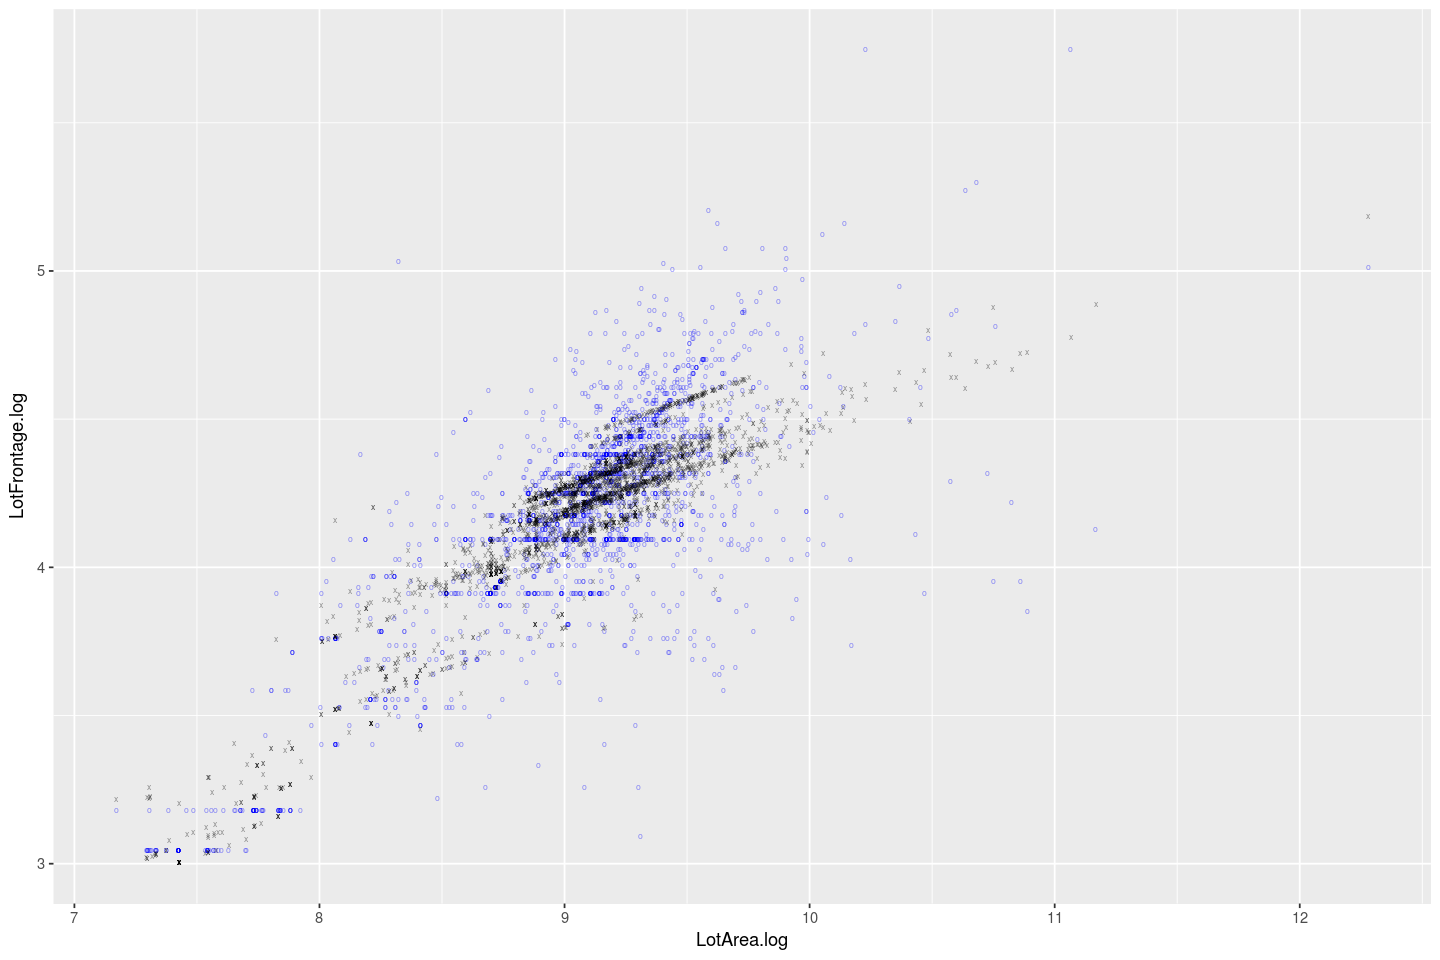

In [14]:
options(repr.plot.width = 12, repr.plot.height = 8)

model.augment = broom::augment(model2.lm)

model.augment %>% 
ggplot() + 
geom_point(aes(x=LotArea.log, y=LotFrontage.log), alpha=0.4, color="blue", shape='o') +
geom_point(aes(x=LotArea.log, y=.fitted), alpha=0.4, color="black", shape='x')

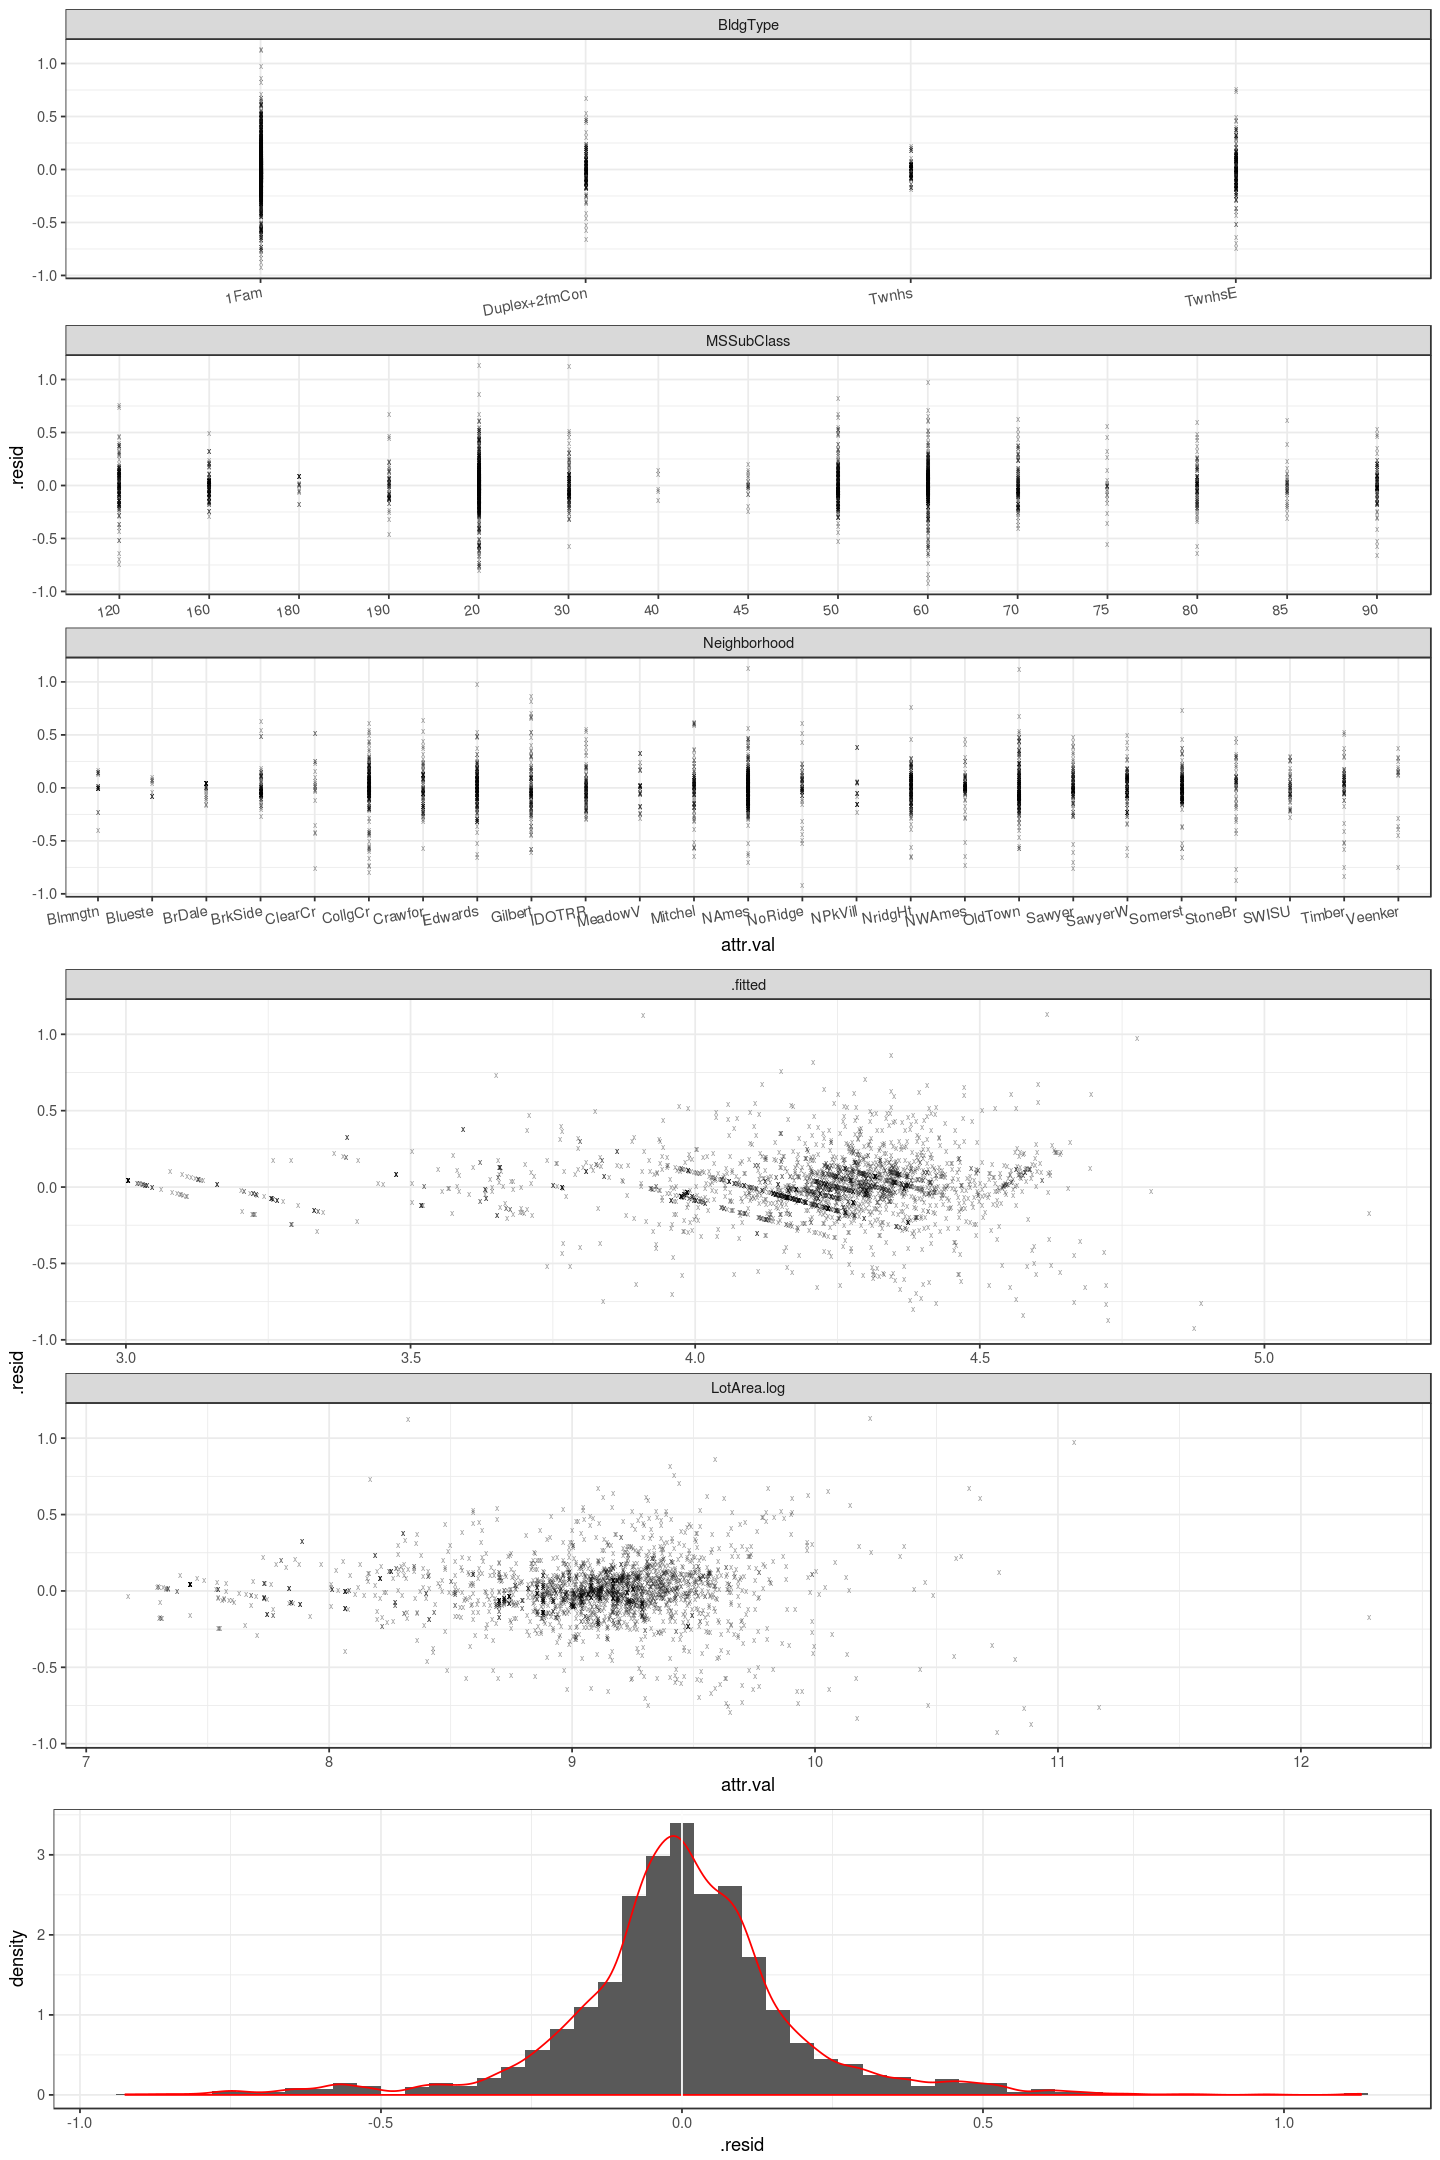

In [15]:
options(repr.plot.width = 12, repr.plot.height = 18)

p1 <- model.augment %>%
select(MSSubClass, BldgType, Neighborhood, .resid) %>%
gather(attr.name, attr.val, -.resid) %>%
group_by(attr.name) %>% 
ggplot() + 
geom_point(aes(x=attr.val, y=.resid), alpha=0.4, color="black", shape='x') +
facet_wrap(~attr.name, scales="free_x", ncol=1) +
theme_bw() +
theme(axis.text.x=element_text(angle=10,hjust=1))

p2 <- model.augment %>%
select(LotArea.log, .fitted, .resid) %>%
gather(attr.name, attr.val, -.resid) %>%
group_by(attr.name) %>% 
ggplot() + 
geom_point(aes(x=attr.val, y=.resid), alpha=0.4, color="black", shape='x') +
facet_wrap(~attr.name, scales="free_x", ncol=1) +
theme_bw()


p3 <- model.augment %>% 
ggplot(aes(.resid, ..density..)) + 
geom_histogram(binwidth = .04) +
geom_density(color="red") + 
geom_vline(color="white", xintercept=0) +
theme_bw()


grid.arrange(p1, p2, p3,
    layout_matrix=rbind(c(1), c(2), c(3)),
    heights=c(8, 7, 3)
)

In [16]:
df.LotFrontage %>%
select(LotFrontage, LotArea, MSSubClass, BldgType, Neighborhood) %>%
na.omit %>%
mutate(
    LotArea.log = log(LotArea),
    LotFrontage.log = log(LotFrontage),
    BldgType = ifelse(BldgType %in% c('Duplex', '2fmCon'), 'Duplex+2fmCon', BldgType)
) -> df

fn <- function (i) { 
    train_index <- caret::createDataPartition(df$LotFrontage.log, p=0.6, times=1, list=FALSE)
    df.train <- df[ train_index,]
    df.test  <- df[-train_index,]
    model.lm <- lm(LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + Neighborhood, data = df.train)
    train_score <- sum(model.lm$residuals^2) / length(model.lm$residuals)
    y_test_predicted <- predict(model.lm, df.test)
    y_test_actual <- df.test$LotFrontage.log
    test_score <- sum( (y_test_predicted - y_test_actual)^2 ) / length(y_test_actual)
    list(train=train_score, test=test_score)
}

pairs <- 1:100 %>% map(fn)
data.frame(
    train_score = pairs %>% map_dbl(function (p) { p$train }),
    test_score = pairs %>% map_dbl(function (p) { p$test })
) %>% head

Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.test):
“prediction from a rank-deficient fit may be misleading”Warning message in predict.lm(model.lm, df.tes

train_score,test_score
0.03799590,0.03865922
0.03720710,0.03983758
0.03475837,0.04410502
0.03691075,0.04153786
0.03991475,0.03574236
0.03777923,0.03913532


In [17]:
df.LotFrontage %>%
select(LotFrontage, LotArea, MSSubClass, BldgType, Neighborhood) %>%
na.omit %>%
mutate(
    LotArea.log = log(LotArea),
    LotFrontage.log = log(LotFrontage),
    BldgType = ifelse(BldgType %in% c('Duplex', '2fmCon'), 'Duplex+2fmCon', BldgType)
) -> df

fn <- function (i) { 
    train_index <- caret::createDataPartition(df$LotFrontage.log, p=0.8, times=1, list=FALSE)
    df.train <- df[ train_index,]
    model.lm <- lm(LotFrontage.log ~ LotArea.log + MSSubClass + BldgType + Neighborhood, data = df.train)
    model.lm
}

models <- 1:100 %>% map(fn)

do.call(rbind, models %>% map(broom::tidy)) %>% 
group_by(term) %>%
summarise(
    min = min(estimate),
    max = max(estimate),
    mean = mean(estimate),
    sd = sd(estimate)
)

term,min,max,mean,sd
BldgTypeDuplex+2fmCon,-0.14632026,0.02284045,-0.058834330,0.03902742
BldgTypeTwnhs,-0.57416964,-0.35675637,-0.475322898,0.04415210
BldgTypeTwnhsE,-0.36984826,-0.17370089,-0.275979194,0.04109722
(Intercept),1.44073421,2.02224266,1.731801341,0.10717198
LotArea.log,0.25925221,0.31209270,0.286447557,0.01075617
MSSubClass160,-0.14250792,-0.05373265,-0.099963428,0.01636992
MSSubClass180,-0.14135346,-0.05191276,-0.097733855,0.01884387
MSSubClass190,-0.01209894,0.33640515,0.131370456,0.06216512
MSSubClass20,0.02126087,0.22698814,0.118671972,0.04188004
MSSubClass30,-0.06689638,0.15503314,0.047755046,0.04340345


term,estimate,std.error,statistic,p.value
(Intercept),-0.7237854,0.09730897,-7.438014,1.524215e-13
LotArea.log,0.5408142,0.01070940,50.499041,0.000000e+00
(Intercept),-0.8951159,0.09505998,-9.416327,1.272370e-20
LotArea.log,0.5601940,0.01047389,53.484827,0.000000e+00
(Intercept),-0.9385578,0.09216805,-10.183115,9.184830e-24
LotArea.log,0.5646985,0.01015715,55.596127,0.000000e+00


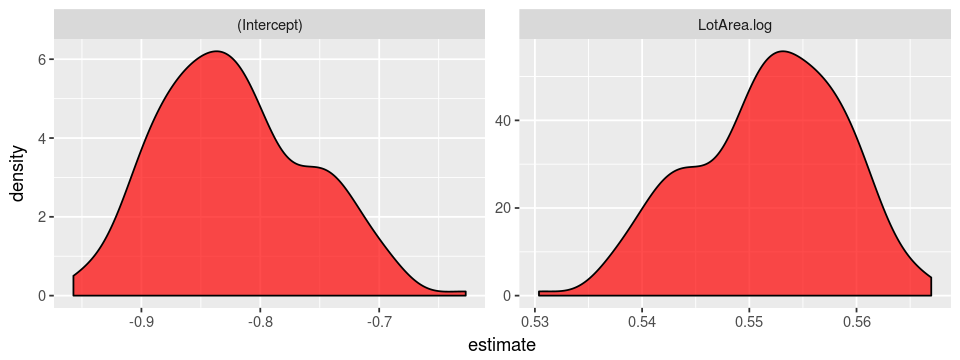

In [30]:
options(repr.plot.width = 8, repr.plot.height = 3)

df.LotFrontage %>%
select(LotFrontage, LotArea, MSSubClass, BldgType, Neighborhood) %>%
na.omit %>%
mutate(
    LotArea.log = log(LotArea),
    LotFrontage.log = log(LotFrontage)
) -> df

fn <- function (i) { 
    train_index <- caret::createDataPartition(df$LotFrontage.log, p=0.8, times=1, list=FALSE)
    df.train <- df[ train_index,]
    model.lm <- lm(LotFrontage.log ~ LotArea.log, data = df.train)
    model.lm
}

models <- 1:200 %>% map(fn)

tidy <- do.call(rbind, models %>% map(broom::tidy))
tidy %>% head

tidy %>%
group_by(term) %>%
ggplot() +
geom_density(aes(estimate), fill = "red", alpha = "0.7") +
facet_wrap(~term, scales="free")

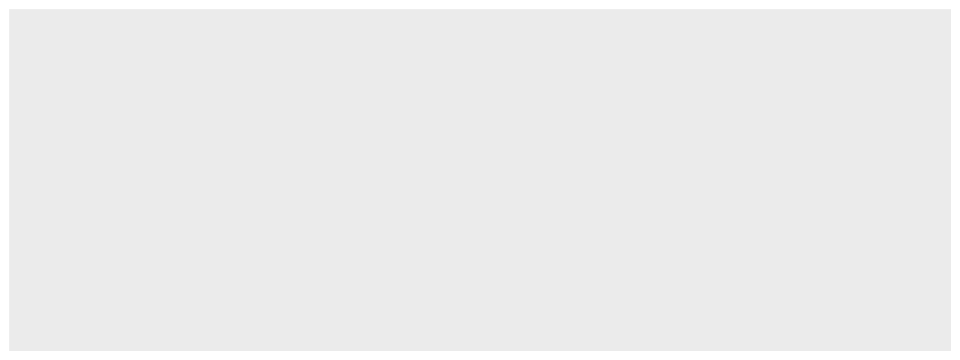

In [74]:
tidy %>% 
select(term, estimate) %>% 
mutate(rownum = 1:n(), groupnum = ifelse(rownum %% 2, rownum %/% 2, rownum %/% 2 - 1)) %>%
select(-rownum) %>%
tidyr::spread(key = term, value = estimate) %>%
select(-groupnum) %>% 
ggplot() +
geom_abline(aes(intercept = 2, slope = LotArea.log))